# 室内场景三维重建 - 课程大作业


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# 导入必要的库
import cv2
from pathlib import Path
from process import *
import process.feature_extraction as fe
import process.feature_matching as fm
from util import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
# 初始化数据保存路径
data_path = Path.cwd() / "data"

## Step0: 导入图像及相机参数


In [5]:
# 是否重新生成数据
regenerate = False
cache_key = "images_and_intrinsics"

images, camera_intrinsic = cache_wrapper(
    cache_key, regenerate, load_images_and_camera_intrinsic
)(data_path)

### 测试：展示图像和相机参数


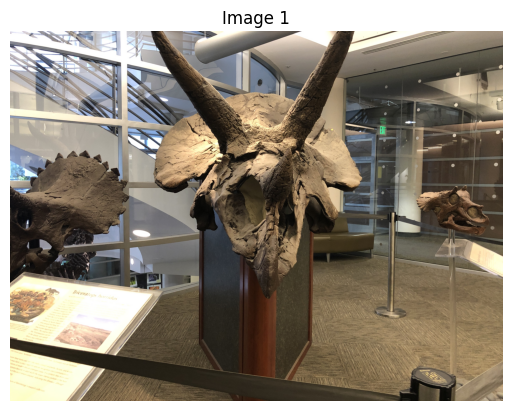

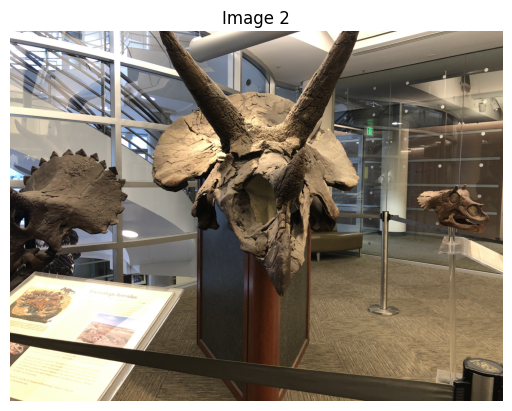

相机内参矩阵:
[[3.2256e+03 0.0000e+00 2.0160e+03]
 [0.0000e+00 3.2256e+03 1.5120e+03]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [6]:
# 展示读取的图像
for i, img in enumerate(images[:2]):
    plt_show(img, f"Image {i+1}")

# 展示相机内参
print("相机内参矩阵:")
print(camera_intrinsic)

## Step1: 图像特征提取 (SIFT)


In [ ]:
regenerate = False
data_cache_key = "sift"

# 运行SIFT特征提取
features = cache_wrapper(
    data_cache_key,
    regenerate,
    extract_features,
    fe.after_load,
)(images)

### 测试：展示图像特征点


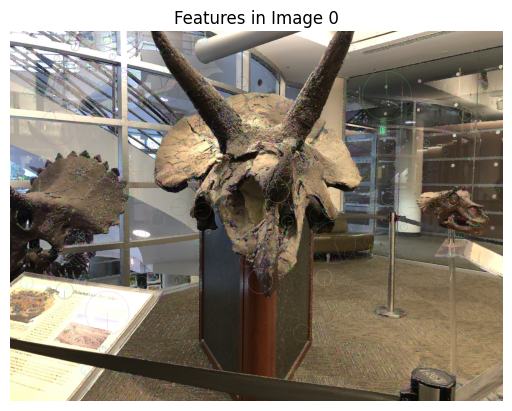

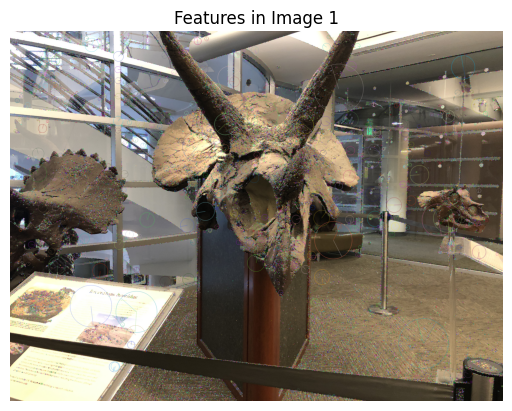

In [ ]:
# 展示特征点
for i, img in enumerate(images[:2]):
    img_with_features = cv2.drawKeypoints(
        img, features[i][0], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    plt_show(img_with_features, f"Features in Image {i}")

## Step2: 图像特征匹配


In [ ]:
# 是否要重新生成该部分数据
regenerate = False
data_cache_key = "matches"

# 运行特征匹配
all_matches = cache_wrapper(
    data_cache_key, regenerate, match_all_paires, fm.after_load
)(features)

### 测试：展示匹配结果


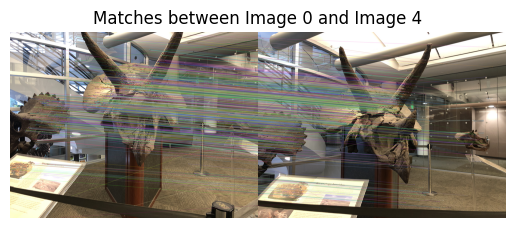

Number of matches: 1539


In [ ]:
img1_indx = 0
img2_indx = 4

# 展示匹配结果
img_matches = visualize_matches(
    images[img1_indx],
    images[img2_indx],
    all_matches[(img1_indx, img2_indx)],
    features[img1_indx],
    features[img2_indx],
)

plt_show(img_matches, f"Matches between Image {img1_indx} and Image {img2_indx}")
print(f"Number of matches: {len(all_matches[(img1_indx, img2_indx)])}")

## Step2.5: 初始化相机


In [ ]:
cameras = []
for i, img in enumerate(images):
    camera = Camera(camera_intrinsic)
    cameras.append(camera)

## Step3: 场景初始化 (对极几何)

In [ ]:
# 初始化重建
points3D, colors3D = init_recon(
    features1=features[0],
    features2=features[1],
    camera1=cameras[0],
    camera2=cameras[1],
    match=all_matches[(0, 1)],
    img1=images[0],
    img2=images[1]
)

基础矩阵:
[[ 2.01834304e-08  7.61706895e-07  3.35687639e-04]
 [-4.81526369e-07  1.09340562e-08  2.08717568e-02]
 [-8.09748982e-04 -2.14503587e-02  1.00000000e+00]]

本质矩阵:
[[  0.20999841   7.92517585   4.92896923]
 [ -5.01003887   0.11376334  64.24599093]
 [ -4.82913303 -64.18371554   0.13051772]]

旋转矩阵:
[[ 9.98996695e-01  1.50304719e-03 -4.47587262e-02]
 [-1.51583963e-03  9.99998819e-01 -2.51869782e-04]
 [ 4.47582948e-02  3.19464131e-04  9.98997794e-01]]

平移向量:
[[ 0.98959601]
 [-0.07617003]
 [ 0.12205677]]



### 测试：展示初始化结果

In [ ]:
# 展示相机位置和点云
# visualize_camera_pose_and_pcd([cameras[1].get_pose()], points3D, colors3D)

## Step4: 场景重建 (PnP)

In [ ]:
# 执行PnP算法来估计相机姿态
cameras_pnp = perform_PnP(points3D, features, cameras, all_matches)
points3D_extended, colors3D_extended = extend_points_cloud(points3D, cameras_pnp, features, all_matches, images)

100%|██████████| 60/60 [00:01<00:00, 41.56it/s]


### 测试：展示重建结果

In [ ]:
# 展示相机位置和点云
camera_poses = [camera.get_pose() for camera in cameras_pnp[1:]]
visualize_camera_pose_and_pcd(camera_poses, points3D_extended, colors3D_extended)

NameError: name 'cameras_pnp' is not defined

## Step5: 场景优化 (Bundle Adjustment)


In [ ]:
# # 执行BA算法来优化相机姿态和点云
# optimized_points3D = perform_BA_on_all(points3D=points3D, cameras=cameras[1:])

In [ ]:
# # 保存优化后的点云数据
# dc.save("optimized_points3D", optimized_points3D)
# dc.save("cameras", cameras)

In [ ]:
# # 加载优化后的点云数据
# optimized_points3D = dc.load("optimized_points3D")
# cameras = dc.load("cameras")

In [ ]:
# # 展示优化后的相机位置和点云
# visualize_camera_pose_and_pcd(
#     [camera.get_pose() for camera in cameras[1:]], optimized_points3D
# )